In [ ]:
!pip install librosa numpy tensorflow scikit-learn seaborn matplotlib imbalanced-learn

In [ ]:
import librosa
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from tensorflow.keras.callbacks import EarlyStopping
from collections import Counter

Streaming output truncated to the last 5000 lines.
Processed: 03-01-05-01-02-01-175.wav → Emotion: 4
Processed: 03-01-05-01-02-01-173.wav → Emotion: 4
Processed: 03-01-05-01-02-01-177.wav → Emotion: 4
Processed: 03-01-05-01-02-01-178.wav → Emotion: 4
Processed: 03-01-05-01-02-01-180.wav → Emotion: 4
Processed: 03-01-05-01-02-01-179.wav → Emotion: 4
Processed: 03-01-05-01-02-01-181.wav → Emotion: 4
Processed: 03-01-05-01-02-01-182.wav → Emotion: 4
Processed: 03-01-05-01-02-01-184.wav → Emotion: 4
Processed: 03-01-05-01-02-01-183.wav → Emotion: 4
Processed: 03-01-05-01-02-01-185.wav → Emotion: 4
Processed: 03-01-05-01-02-01-187.wav → Emotion: 4
Processed: 03-01-05-01-02-01-186.wav → Emotion: 4
Processed: 03-01-05-01-02-01-188.wav → Emotion: 4
Processed: 03-01-05-01-02-01-189.wav → Emotion: 4
Processed: 03-01-05-01-02-01-192.wav → Emotion: 4
Processed: 03-01-05-01-02-01-190.wav → Emotion: 4
Processed: 03-01-05-01-02-01-191.wav → Emotion: 4
Processed: 03-01-05-01-02-01-194.wav → Emotion: 4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.2594 - loss: 3.2992 - val_accuracy: 0.4333 - val_loss: 1.4283
Epoch 2/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.3624 - loss: 1.5049 - val_accuracy: 0.4469 - val_loss: 1.3561
Epoch 3/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4256 - loss: 1.3904 - val_accuracy: 0.5040 - val_loss: 1.2319
Epoch 4/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.4298 - loss: 1.3464 - val_accuracy: 0.5008 - val_loss: 1.2443
Epoch 5/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4438 - loss: 1.3290 - val_accuracy: 0.5064 - val_loss: 1.2311
Epoch 6/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4592 - loss: 1.3009 - val_accuracy: 0.5212 - val_loss: 1.2008
Epoch 7/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4686 - loss: 1.2901 - val_accuracy: 0.4569 - val_loss: 1.3143
Epoch 8/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.4877 - loss: 1.2412 - va

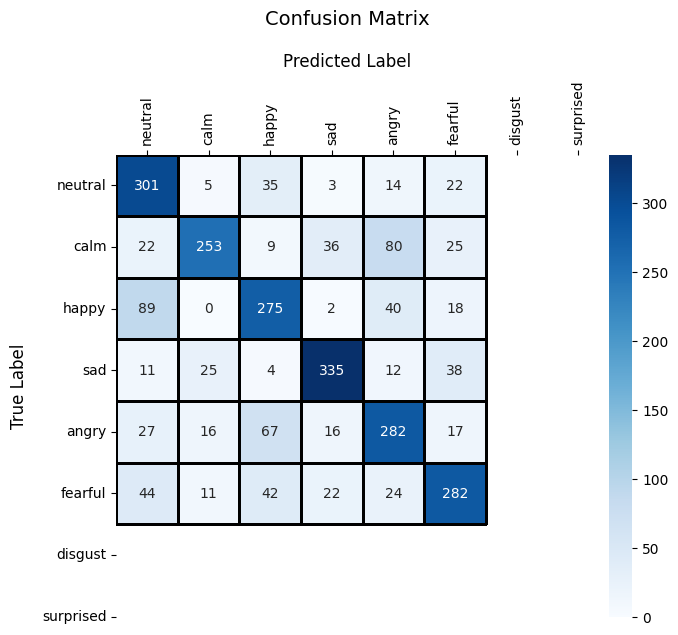

Model saved to cnn_model.h5


In [ ]:
DATASET_PATH = "/content/drive/MyDrive/Speech Audio Datasets"
EMOTION_LABELS = {
    0: "neutral",
    1: "calm",
    2: "happy",
    3: "sad",
    4: "angry",
    5: "fearful",
    6: "disgust",
    7: "surprised"
}
FEATURE_MATRIX_PATH = "X_mel.npy"
LABELS_PATH = "y_mel.npy"
MODEL_PATH = "cnn_model.h5"

# Extract Mel-Spectrogram
def extract_mel_spectrogram(file_path):
    signal, sr = librosa.load(file_path, sr=16000)
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_db = tf.image.resize(mel_spec_db[..., np.newaxis], [128, 128]).numpy()
    return mel_spec_db

# Prepare Dataset
def prepare_dataset():
    features = []
    labels = []
    for root, _, files in os.walk(DATASET_PATH):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                try:
                    emotion_code = int(file.split("-")[2]) - 1
                    if emotion_code not in [1, 7]:  # Skipping calm (1) and surprised (7) cause ofc there are not sufficient files
                        features.append(extract_mel_spectrogram(file_path))
                        labels.append(emotion_code)
                        print(f"Processed: {file} → Emotion: {emotion_code}")
                except (IndexError, ValueError):
                    print(f"Skipping file with invalid name: {file}")
                    continue
    np.save(FEATURE_MATRIX_PATH, np.array(features))
    np.save(LABELS_PATH, np.array(labels))
    print(f"Saved features to {FEATURE_MATRIX_PATH} and {LABELS_PATH}")
    # Print label distribution
    print("Label distribution:", Counter(labels))

# Plot Confusion Matrix
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                     xticklabels=labels, yticklabels=labels,
                     linewidths=1, linecolor='black', square=True,
                     cbar_kws={"orientation": "vertical"})
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xlabel("Predicted Label", fontsize=12, labelpad=10)
    plt.ylabel("True Label", fontsize=12, labelpad=10)
    plt.title("Confusion Matrix", fontsize=14, pad=20)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# Train the CNN Model
def train_model():
    X = np.load(FEATURE_MATRIX_PATH)
    y = np.load(LABELS_PATH)

    # Normalizing features here
    X = (X - X.mean()) / X.std()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )


    print("Label distribution in training set:", Counter(y_train))

    # here's the CNN baby!!
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),  # Added deeper 4th layer
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(8, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=50, batch_size=16,
                        validation_data=(X_test, y_test), callbacks=[early_stopping])


    y_pred = np.argmax(model.predict(X_test), axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:")
    plot_confusion_matrix(cm, list(EMOTION_LABELS.values()))

    model.save(MODEL_PATH)
    print(f"Model saved to {MODEL_PATH}")

# XperiaSER Predict on New Audio file
def predict_emotion(file_path):
    model = tf.keras.models.load_model(MODEL_PATH)
    features = extract_mel_spectrogram(file_path)
    features = (features - features.mean()) / features.std()
    features = features[np.newaxis, ...]
    emotion_code = np.argmax(model.predict(features), axis=1)[0]
    return EMOTION_LABELS[emotion_code]

if __name__ == "__main__":
    prepare_dataset()
    train_model()

In [ ]:
print("\nGive me an audio file, and I'll tell you its emotions!")
xz = input("Enter file path here: ")
print(f"\nYour speech conveys '{predict_emotion(xz)}' emotion!")


Give me an audio file, and I'll tell you its emotions!


In [ ]:
def check_dataset():
    emotion_counts = {i: 0 for i in range(8)}
    for root,_, files in os.walk(DATASET_PATH):
      for file in files:
        if file.endswith(".wav"):
            emotion_code = int(file.split("-")[2]) - 1
            emotion_counts [emotion_code] += 1
    total = sum(emotion_counts.values())
    print(f"Total files: {total}")
    for code, count in emotion_counts.items():
      print (f" {EMOTION_LABELS [code]}: {count} files")
check_dataset()